# EYE FOR BLIND
This notebook will be used to prepare the capstone project 'Eye for Blind'

In [1]:
#Importing  all the required libraries

#System libraries
import os, time, glob
from tqdm import tqdm
from glob import glob
import pickle
from sys import getsizeof

# Date and Time 
import datetime,time

# Data manipulation
import numpy as np
import pandas as pd
import collections, random, re
from collections import Counter

# Model building 
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

#Read/Display  images
from skimage import io
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

import warnings
warnings.filterwarnings("ignore")

# import tensorflow libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import plot_model


Let's read the dataset

## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create word-to-index and index-to-word mappings.

4.Create a dataframe which summarizes the image, path & captions as a dataframe

5.Visualise the top 30 occuring words in the captions

6.Create a list which contains all the captions & path


In [2]:
#Importing the dataset and reading the image into a seperate variable
images='Flickr8K/Images'
all_imgs = glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


In [3]:
#Visualizing both the images & text present in the dataset
def plot_image(images, captions=None, cmap=None ):
    f, axes = plt.subplots(1, len(images), sharey=True)
    f.set_figwidth(15)
   
    for ax,image in zip(axes, images):
        ax.imshow(io.imread(image), cmap)

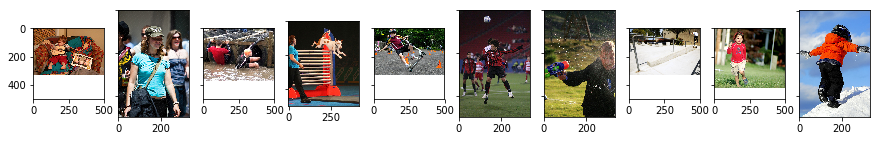

In [4]:
#Plotting first 10 images 
plot_image(all_imgs[0:10])

In [5]:
#Importing the dataset and reading the text file into a seperate variable
text_file = 'Flickr8K/captions.txt'

def load_doc(filename):
    
    file = open(filename)
    text = file.read()
    file.close()
    
    return text

doc = load_doc(text_file)
print(doc[:300])

image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing


In [6]:
# Creating a dataframe which summarizes the image, path & captions as a dataframe
def get_img_ids_and_captions(text):
    keys=[]
    values=[]
    key_paths=[]
    text=text.splitlines()[1:]
    for line in text:
        com_idx=line.index(",")
        im_id,im_cap=line[:com_idx],line[com_idx+1:]
        keys.append(im_id)
        values.append(im_cap)
        key_paths.append('Flickr8K/Images'+'/'+im_id)
    return keys,key_paths, values

In [7]:
all_img_id, all_img_vector, annotations = get_img_ids_and_captions(doc)
df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions']) 
    
df

,ID,Path,Captions
0,1000268201_693b08cb0e.jpg,Flickr8K/Images/1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,Flickr8K/Images/1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,Flickr8K/Images/1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,Flickr8K/Images/1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,Flickr8K/Images/1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
5,1001773457_577c3a7d70.jpg,Flickr8K/Images/1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
6,1001773457_577c3a7d70.jpg,Flickr8K/Images/1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with...
7,1001773457_577c3a7d70.jpg,Flickr8K/Images/1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots a...
8,1001773457_577c3a7d70.jpg,Flickr8K/Images/1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each o...
9,1001773457_577c3a7d70.jpg,Flickr8K/Images/1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .


- Each image id has 5 captions associated with it therefore the total dataset has 40455 samples.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40455 entries, 0 to 40454
Data columns (total 3 columns):
ID          40455 non-null object
Path        40455 non-null object
Captions    40455 non-null object
dtypes: object(3)
memory usage: 948.3+ KB


In [9]:
def plot_image_captions(Pathlist,captionsList,fig,count=2,npix=299,nimg=2):
        image_load = load_img(Path,target_size=(npix,npix,3))
        ax = fig.add_subplot(nimg,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        
        count +=1
        ax = fig.add_subplot(nimg,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,len(captions))
        for i, caption in enumerate(captions):
            ax.text(0,i,caption,fontsize=20)

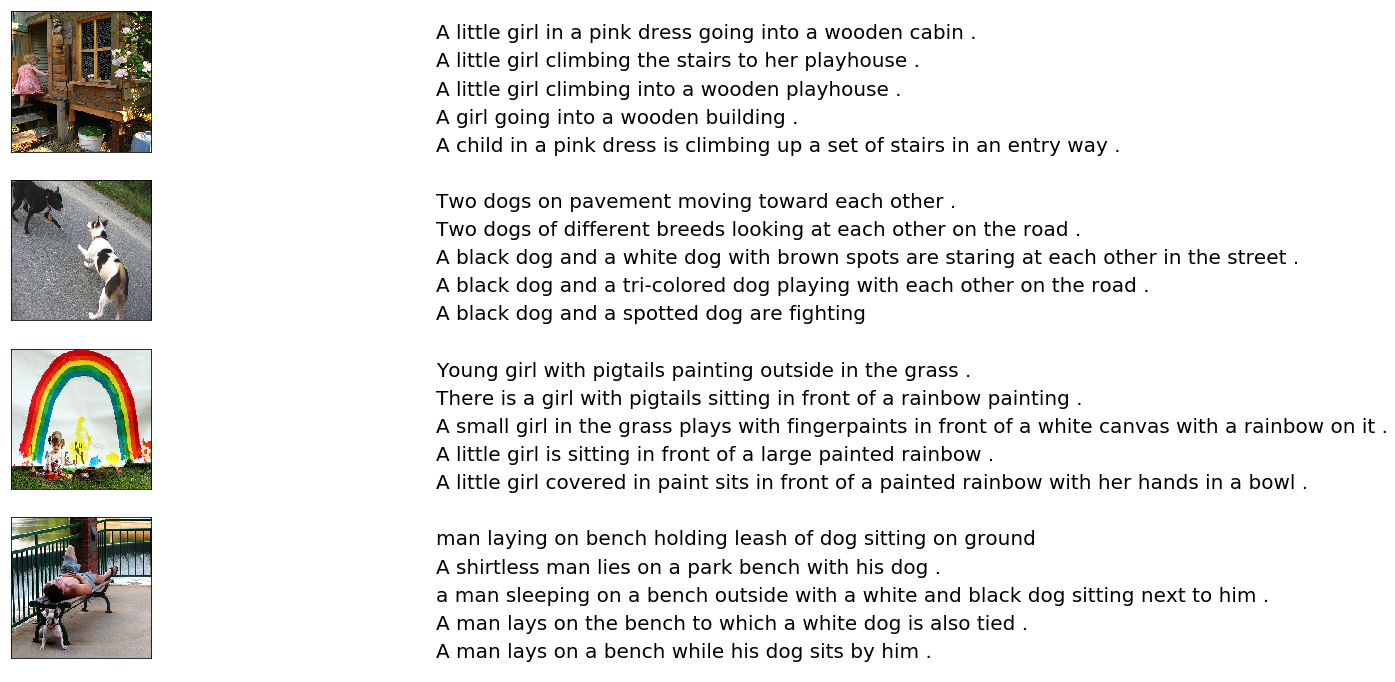

In [10]:
# Getting Images and captions altogether
fig = plt.figure(figsize=(20,15))
count = 1
    
for Path in df[:20].Path.unique():
    captions = list(df["Captions"].loc[df.Path== Path].values)
    plot_image_captions(Path,captions,fig,count,299,5)
    count +=2
plt.show()

In [11]:
def split_sentence(sentence):
    return list(filter(lambda x: len(x) > 0, re.split('\W+', sentence.lower()))) 
# To avoid duplication of words, i have made each word into smaller case

def generate_vocabulary(captions):
    words = []
    for sentence in captions:
        sent_words = split_sentence(sentence)
        for word in sent_words: 
            words.append(word)
    return sorted(words)
    
vocab = generate_vocabulary(df.Captions)

In [12]:
## Creating vocabulary of all words present in captions

vocabulary =  Counter(vocab)

df_word = pd.DataFrame.from_dict(vocabulary, orient='index')
df_word = df_word.sort_values(by=[0],ascending=False).reset_index()
df_word =df_word.rename(columns={'index':'word', 0:'count'})

In [13]:
df_word.head()

,word,count
0,a,62992
1,in,18986
2,the,18419
3,on,10745
4,is,9345


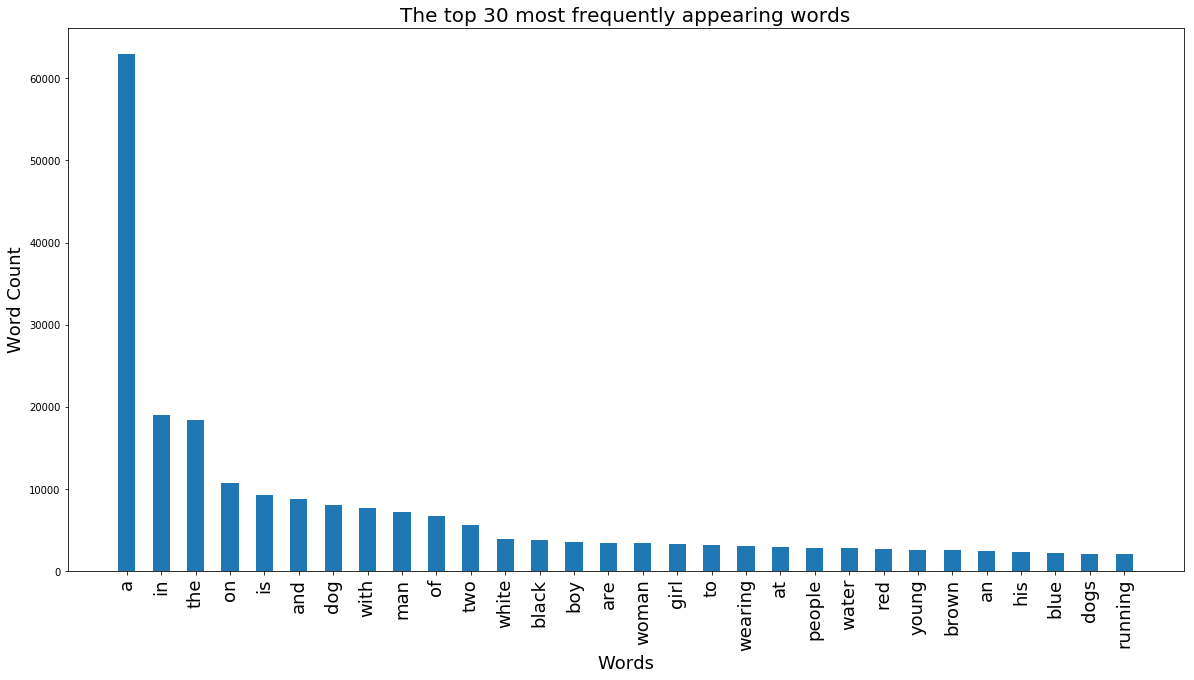

In [14]:
#Visualizing the top 30 occuring words in the captions
def plthist(index,words,count, title="The top 30 most frequently appearing words"):
    plt.figure(figsize=(20,10))
    plt.bar(words,count, width =0.5)
    plt.xlabel("Words",  fontsize=18) 
    plt.ylabel("Word Count",rotation=90,fontsize=18) 
    plt.xticks(index,words,rotation=90,fontsize=18)
    plt.title(title,fontsize=20)
    plt.show()
    
words = list(df_word[:30].word)

count =list(df_word['count'][:30])
plthist(list(range(0,30)),words,count)

In [15]:
#Create a list which contains all the captions
annotations=df.Captions.apply(lambda z:"<start>"+" "+z+" "+"<end>")

#add the <start> & <end> token to all those captions as well
#adding  the <start> & <end> token to all the captions 
df['Captions']=df.Captions.apply(lambda x : f"<start> {x} <end>")
# Find max length of sequence
max_length = max(df.Captions.apply(lambda x : len(x.split())))

#Create a list which contains all the path to the images
unique_img_path= sorted(set(all_img_vector))

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_vector)))
print("Unique images present in the dataset: " + str(len(unique_img_path)))

Total captions present in the dataset: 40455
Total images present in the dataset: 40455
Unique images present in the dataset: 8091


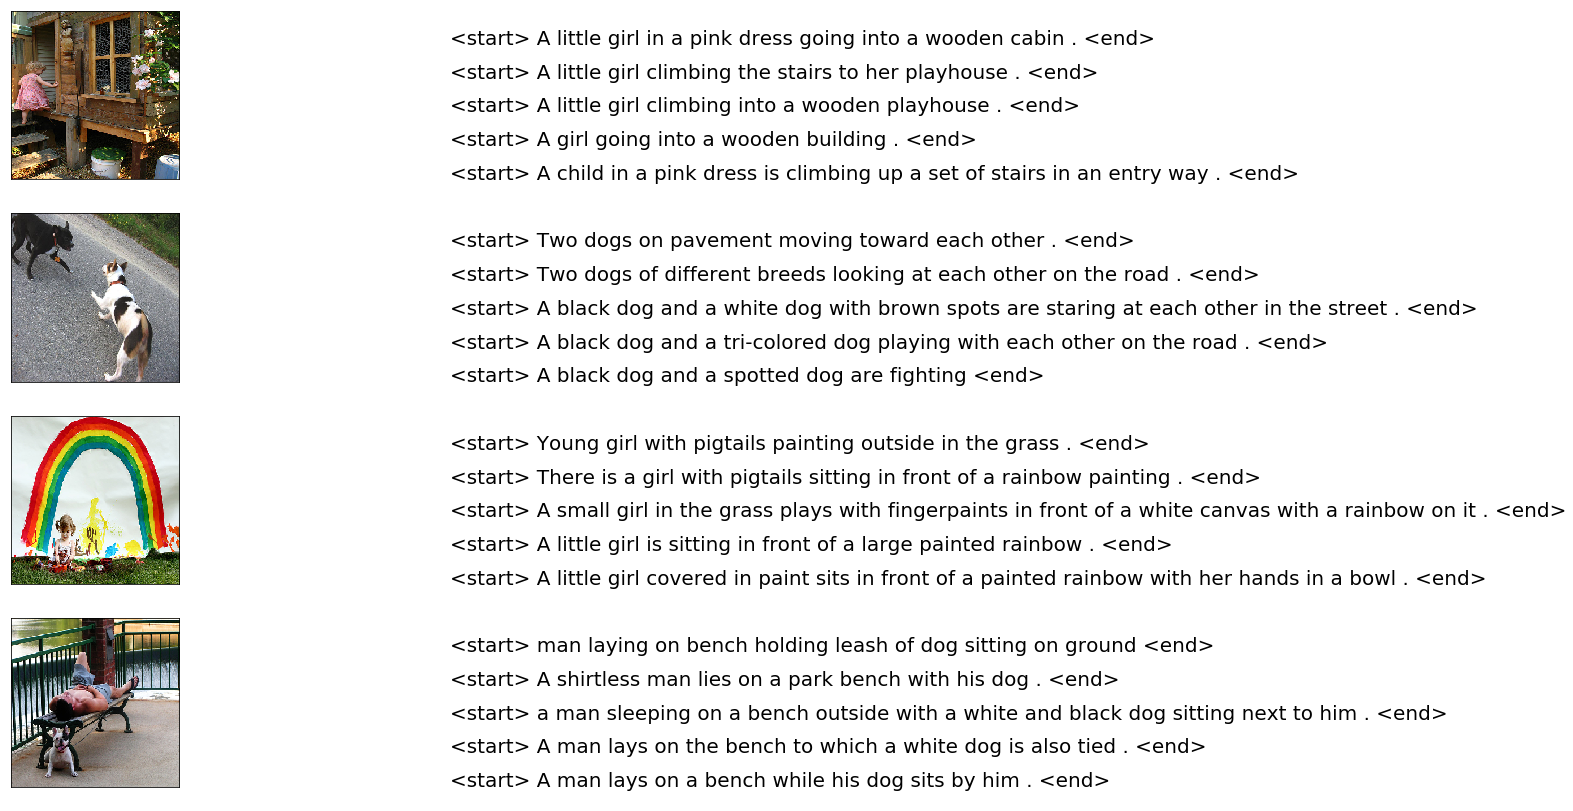

In [16]:
# Images 
fig = plt.figure(figsize=(20,18))
count = 1
    
for Path in df[:20].Path.unique():
    captions = list(df["Captions"].loc[df.Path== Path].values)
    plot_image_captions(Path,captions,fig,count,299,5)
    count +=2
plt.show()

## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [17]:
vocabulary =  Counter(vocab)

In [18]:
# create the tokenizer
top_word_cnt = 5000
special_chars = '!"#$%&()*+.,-/:;=?@[\]^_`{|}~ '
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_word_cnt,
                                                  oov_token="<unk>",
                                                  filters=special_chars)
tokenizer.fit_on_texts(annotations)
train_seqs = tokenizer.texts_to_sequences(annotations)

In [19]:
train_seqs[:5]

[[3, 2, 44, 5, 2, 91, 173, 8, 120, 52, 2, 394, 13, 395, 5, 29, 1, 671, 4],
 [3, 2, 20, 317, 65, 2, 197, 118, 4],
 [3, 2, 41, 20, 120, 65, 2, 197, 2438, 4],
 [3, 2, 41, 20, 120, 6, 395, 21, 61, 2438, 4],
 [3, 2, 41, 20, 5, 2, 91, 173, 317, 65, 2, 197, 2982, 4]]

In [20]:
annotations[:5]

0    <start> A child in a pink dress is climbing up...
1    <start> A girl going into a wooden building . ...
2    <start> A little girl climbing into a wooden p...
3    <start> A little girl climbing the stairs to h...
4    <start> A little girl in a pink dress going in...
Name: Captions, dtype: object

In [21]:
# Creating word-to-index and index-to-word mappings.
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'
train_seqs = tokenizer.texts_to_sequences(annotations)

In [22]:
tokenizer.word_counts

OrderedDict([('<start>', 40455),
             ('a', 62992),
             ('child', 1545),
             ('in', 18986),
             ('pink', 739),
             ('dress', 348),
             ('is', 9345),
             ('climbing', 507),
             ('up', 1302),
             ('set', 109),
             ('of', 6723),
             ('stairs', 109),
             ('an', 2432),
             ('entry', 1),
             ('way', 53),
             ('<end>', 40455),
             ('girl', 3328),
             ('going', 149),
             ('into', 1074),
             ('wooden', 284),
             ('building', 510),
             ('little', 1768),
             ('playhouse', 6),
             ('the', 18419),
             ('to', 3176),
             ('her', 1178),
             ('cabin', 4),
             ('black', 3848),
             ('dog', 8138),
             ('and', 8862),
             ('spotted', 38),
             ('are', 3504),
             ('fighting', 133),
             ('tri', 14),
             ('color

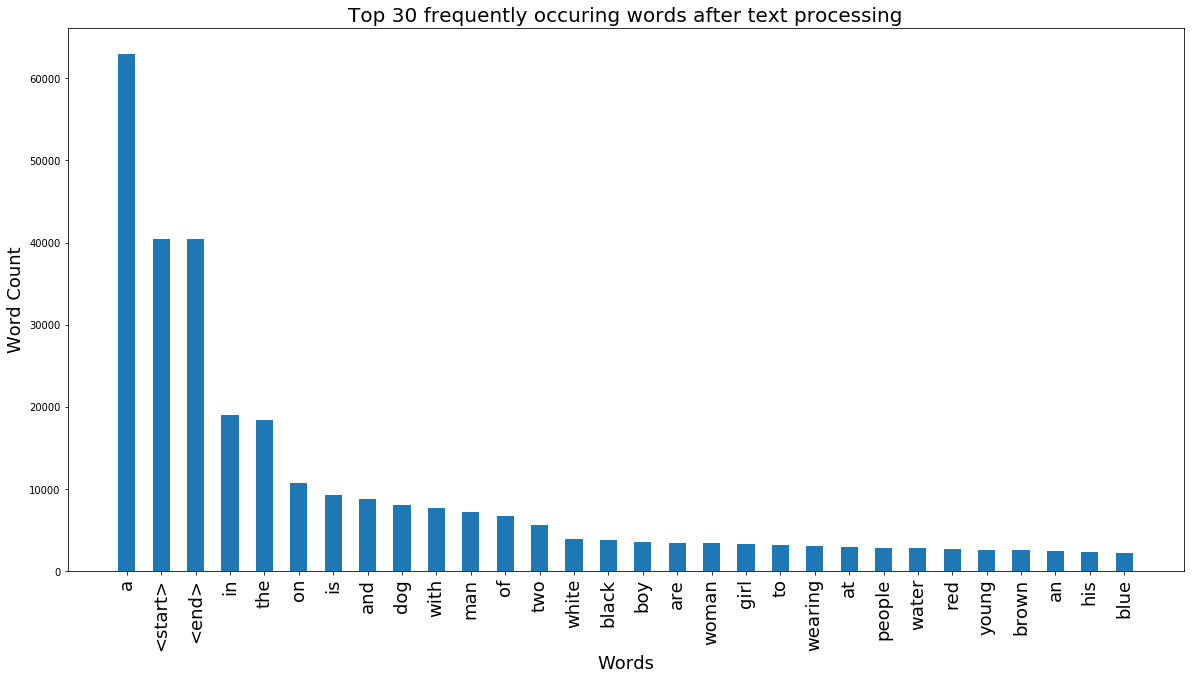

In [23]:
# Creating word count of tokenizer to visulize the Top 30 occuring words after text processing
word_counts = tokenizer.word_counts
df_word = pd.DataFrame.from_dict(word_counts, orient = 'index')
df_word = df_word.sort_values(by = [0], ascending=False).reset_index()
df_word = df_word.rename(columns={'index':'word', 0:'count'})

words = list(df_word[:30].word)
count =list(df_word['count'][:30])
plthist(list(range(0,30)),words,count, title='Top 30 frequently occuring words after text processing')

In [24]:
# Padding each vector to the max_length of the captions ^ store it to a vairable
max_len = max([len(cap) for cap in train_seqs])
cap_vector= tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post',maxlen=max_len)
print("The shape of Caption vector:" + str(cap_vector.shape))

The shape of Caption vector:(40455, 39)


In [25]:
cap_vector

array([[ 3,  2, 44, ...,  0,  0,  0],
       [ 3,  2, 20, ...,  0,  0,  0],
       [ 3,  2, 41, ...,  0,  0,  0],
       ...,
       [ 3,  2, 45, ...,  0,  0,  0],
       [ 3,  2, 86, ...,  0,  0,  0],
       [ 3,  2, 86, ...,  0,  0,  0]], dtype=int32)

## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

In [26]:
def preprocess_image(image_path, shape = (299, 299)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image,channels=3)
    image = tf.image.resize(image,shape)
    image = tf.keras.applications.inception_v3.preprocess_input(image)
    return image, image_path

W0208 08:42:46.006407 139993086515008 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Shape after resizing : (299, 299, 3)


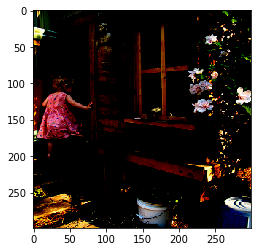

In [27]:
print("Shape after resizing :", preprocess_image(unique_img_path[0])[0].shape)
plt.imshow(preprocess_image(unique_img_path[0])[0])

In [28]:
encode_train_set = sorted(set(all_img_vector))

image_dataset = tf.data.Dataset.from_tensor_slices(encode_train_set)
image_dataset = image_dataset.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32)
image_dataset

<BatchDataset shapes: ((None, 299, 299, 3), (None,)), types: (tf.float32, tf.string)>

## Create the train & test data 
1.Combine both images & captions to create the train & test dataset using tf.data.Dataset API. Create the train-test spliit using 80-20 ratio & random state = 42

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 299, 299, 3)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [29]:
# train-test split
image_train, image_test, caption_train, caption_test = train_test_split(all_img_vector,cap_vector, test_size=0.2, random_state=42)

In [30]:
print("Training data for images: " + str(len(image_train)))
print("Testing data for images: " + str(len(image_test)))
print("Training data for Captions: " + str(len(caption_train)))
print("Testing data for Captions: " + str(len(caption_test)))

Training data for images: 32364
Testing data for images: 8091
Training data for Captions: 32364
Testing data for Captions: 8091


In [31]:
sample_img_batch, sample_cap_batch = next(iter(image_dataset))
print(sample_img_batch.shape) #(batch_size, 299, 299, 3)
print(sample_cap_batch.shape) #(batch_size, max_len)

(32, 299, 299, 3)
(32,)


## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of thei mage using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [32]:
img_mod = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')
new_input = img_mod.input
hidden_layer = img_mod.layers[-1].output
image_features_extract_model =  tf.compat.v1.keras.Model(new_input, hidden_layer)

In [33]:
image_features_extract_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [34]:
# write your code to extract features from each image in the dataset
feature_dict = {}
for image,path in tqdm(image_dataset):
    batch_features = image_features_extract_model(image)
    batch_features = tf.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3]))
    for batch_f, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        feature_dict[path_of_feature] =  batch_f.numpy()

253it [00:51,  1.90it/s]


In [35]:
def map_function(img_name,capt):
    image_tensor = feature_dict[img_name.decode('utf-8')]
    return image_tensor,capt

In [36]:
def generate_dataset(img_data, cap_data, BATCH_SIZE =32, BUFFER_SIZE = 1000):
    
    dataset = tf.data.Dataset.from_tensor_slices((img_data, cap_data))
    dataset = dataset.shuffle(BUFFER_SIZE)

    dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_function, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE)


    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [37]:
train_dataset=generate_dataset(image_train,caption_train)
test_dataset=generate_dataset(image_test,caption_test)

In [38]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,40)

(32, 64, 2048)
(32, 39)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [39]:
BATCH_SIZE = 32
embedding_dim = 256 
units = 512
vocab_size = 5001 
#top 5,000 words +1
train_num_steps = len(image_train) // BATCH_SIZE
test_num_steps = len(image_test) // BATCH_SIZE

### Encoder

In [40]:
tf.version

<module 'tensorflow._api.v2.version' from '/mnt/disks/user/anaconda3/lib/python3.7/site-packages/tensorflow/_api/v2/version/__init__.py'>

In [41]:
tf.compat.v1.reset_default_graph() #inorder to resolve compatibility issue from tensorflow

In [42]:
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embed_dim)
        self.dropout = tf.keras.layers.Dropout(0.5)
        
    def call(self, features):
        # extracting the features from the image shape: (batch, 8*8, embed_dim)
        features =  self.dense(features) 
        features = tf.keras.activations.relu(features, alpha=0.01, max_value=None, threshold=0) #applying relu activation 
        return features

In [43]:
encoder=Encoder(embedding_dim)

### Attention model

In [44]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units) #building Dense layer
        self.V = tf.keras.layers.Dense(1) #building final Dense layer with unit 1
        self.units=units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1) # Expanding the hidden shape to shape: (batch_size, 1, hidden_size)
        score = tf.keras.activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis)) # building score function to shape: (batch_size, 8*8, units)
        attention_weights =  tf.keras.activations.softmax(self.V(score), axis=1) # extracting attention weights with shape: (batch_size, 8*8, 1)
        con_vec = attention_weights * features # creating the context vector with shape (batch_size, 8*8,embedding_dim)
        con_vec = tf.reduce_sum(con_vec, axis = 1) # reducing the shape to (batch_size, embedding_dim)

        return con_vec, attention_weights

### Decoder

In [45]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units) #iniitalizing my Attention model with units
        self.embed = tf.keras.layers.Embedding(vocab_size, embed_dim, mask_zero =  False) #building Embedding layer
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = tf.keras.layers.Dense(self.units) #building Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size) #building Dense layer
        self.dropout = tf.keras.layers.Dropout(0.5)
        

    def call(self,x,features, hidden):
        con_vec, attention_weights =self.attention(features, hidden) #creating context vector & attention weights from attention model
        embed =  self.dropout(self.embed(x)) # embeding input to shape: (batch_size, 1, embedding_dim)
        mask = self.embed.compute_mask(x) 
        embed = tf.concat([tf.expand_dims(con_vec, 1), embed], axis=-1) # Concatenating input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state = self.gru(embed, mask = mask) # Extracting the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)
        
        return output,state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [46]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [47]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape coming from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predictions shape coming from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape coming from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape coming from Encoder: (32, 64, 256)
Predictions shape coming from Decoder: (32, 5001)
Attention weights shape coming from Decoder: (32, 64, 1)


## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [48]:
optimizer = keras.optimizers.Adam() #defining the optimizer
loss_object = keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none') #defining loss object

In [49]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [50]:
checkpoint_path = "Flickr8K/File3/"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [51]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [52]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        features = encoder(img_tensor,training =True)
        
        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)
            
        total_loss = (loss/int(target.shape[1]))
        trainable_variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))
        
    return loss, total_loss

In [53]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)

        avg_loss = (loss / int(target.shape[1]))

        trainable_variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))
        
    return loss, avg_loss

In [54]:
def test_loss_cal(test_dataset):
    total_loss = 0
    # code to get the average loss result on test data
    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss
    avg_test_loss=total_loss/test_num_steps
    
    return avg_test_loss

In [55]:
loss_plot = []
test_loss_plot = []
EPOCHS = 15
best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0
    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  7%|▋         | 1/15 [04:06<57:35, 246.84s/it]

For epoch: 1, the train loss is 1.192, & test loss is 1.012
Time taken for 1 epoch 246.71426653862 sec

Test loss has been reduced from 100.000 to 1.012


 13%|█▎        | 2/15 [06:17<45:55, 211.93s/it]

For epoch: 2, the train loss is 0.940, & test loss is 0.899
Time taken for 1 epoch 130.3797163963318 sec

Test loss has been reduced from 1.012 to 0.899


 20%|██        | 3/15 [08:27<37:30, 187.53s/it]

For epoch: 3, the train loss is 0.855, & test loss is 0.829
Time taken for 1 epoch 130.46887397766113 sec

Test loss has been reduced from 0.899 to 0.829


 27%|██▋       | 4/15 [10:38<31:13, 170.35s/it]

For epoch: 4, the train loss is 0.793, & test loss is 0.771
Time taken for 1 epoch 130.14129066467285 sec

Test loss has been reduced from 0.829 to 0.771


 33%|███▎      | 5/15 [12:48<26:23, 158.36s/it]

For epoch: 5, the train loss is 0.741, & test loss is 0.721
Time taken for 1 epoch 130.24636125564575 sec

Test loss has been reduced from 0.771 to 0.721


 40%|████      | 6/15 [14:58<22:28, 149.88s/it]

For epoch: 6, the train loss is 0.695, & test loss is 0.677
Time taken for 1 epoch 129.9737195968628 sec

Test loss has been reduced from 0.721 to 0.677


 47%|████▋     | 7/15 [17:09<19:12, 144.03s/it]

For epoch: 7, the train loss is 0.654, & test loss is 0.636
Time taken for 1 epoch 130.26931619644165 sec

Test loss has been reduced from 0.677 to 0.636


 53%|█████▎    | 8/15 [19:19<16:19, 139.89s/it]

For epoch: 8, the train loss is 0.614, & test loss is 0.598
Time taken for 1 epoch 130.09930682182312 sec

Test loss has been reduced from 0.636 to 0.598


 60%|██████    | 9/15 [21:29<13:42, 137.04s/it]

For epoch: 9, the train loss is 0.578, & test loss is 0.564
Time taken for 1 epoch 130.28280448913574 sec

Test loss has been reduced from 0.598 to 0.564


 67%|██████▋   | 10/15 [23:39<11:14, 134.96s/it]

For epoch: 10, the train loss is 0.546, & test loss is 0.532
Time taken for 1 epoch 129.9797785282135 sec

Test loss has been reduced from 0.564 to 0.532


 73%|███████▎  | 11/15 [25:50<08:54, 133.57s/it]

For epoch: 11, the train loss is 0.517, & test loss is 0.503
Time taken for 1 epoch 130.21213960647583 sec

Test loss has been reduced from 0.532 to 0.503


 80%|████████  | 12/15 [28:00<06:37, 132.55s/it]

For epoch: 12, the train loss is 0.489, & test loss is 0.478
Time taken for 1 epoch 130.04074931144714 sec

Test loss has been reduced from 0.503 to 0.478


 87%|████████▋ | 13/15 [30:10<04:23, 131.95s/it]

For epoch: 13, the train loss is 0.465, & test loss is 0.455
Time taken for 1 epoch 130.4476718902588 sec

Test loss has been reduced from 0.478 to 0.455


 93%|█████████▎| 14/15 [32:20<02:11, 131.39s/it]

For epoch: 14, the train loss is 0.443, & test loss is 0.433
Time taken for 1 epoch 129.9764802455902 sec

Test loss has been reduced from 0.455 to 0.433


100%|██████████| 15/15 [34:31<00:00, 131.01s/it]

For epoch: 15, the train loss is 0.423, & test loss is 0.415
Time taken for 1 epoch 129.99655890464783 sec

Test loss has been reduced from 0.433 to 0.415


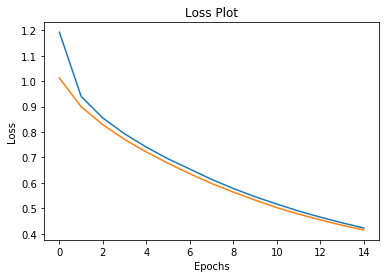

In [56]:
#loss plot 
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

- Notice the loss decreases converges as epochs increases

## Model Evaluation
1.Defining your evaluation function using greedy search

2.Defining your evaluation function using beam search ( optional)

3.Testing it on a sample data using BLEU score

### Greedy Search

In [113]:
def evaluate(image):

    attention_plot = np.zeros((max_len, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(preprocess_image(image)[0], 0) #processing the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input)# Extracting features using our feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)# extracting the features by passing the input to encoder

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)# getting the output from decoder
        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
        predicted_id =tf.argmax(predictions[0]).numpy() #extracting the predicted id(embedded value) which carries the max value
        result.append(tokenizer.index_word[predicted_id])#mapping the id to the word from tokenizer and append the value to the result list

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions
        
        dec_input = tf.expand_dims([predicted_id], 0)
        
    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions


### Beam Search(optional)

In [114]:
def beam_evaluate(image, beam_index = 3):
    max_length=max_len
    start = [tokenizer.word_index['<start>']]
    result = [[start, 0.0]]

    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(preprocess_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)

    while len(result[0][0]) < max_length:
        i=0
        temp = []
        for s in result:
            predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
            attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
            i=i+1
            word_preds = np.argsort(predictions[0])[-beam_index:]
          
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += np.log(predictions[0][w])  
                temp.append([next_cap, prob])
        
        result = temp
        result = sorted(result, reverse=False, key=lambda l: l[1])
        result = result[-beam_index:]
        
        predicted_id = result[-1]
        pred_list = predicted_id[0]
        prd_id = pred_list[-1] 
        
        if(prd_id!=3):
            dec_input = tf.expand_dims([prd_id], 0)  
        else:
            break
    
    result2 = result[-1][0]
    intermediate_caption = [tokenizer.index_word[i] for i in result2]
    final_caption = []
    
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)        
        else:
            break
    attention_plot = attention_plot[:len(result), :]
    final_caption = ' '.join(final_caption[1:]) 
    return final_caption

In [115]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    len_cap = len(caption)
    
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        img=ax.imshow(temp_img)
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
        
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [116]:
from nltk.translate.bleu_score import sentence_bleu

In [117]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [118]:
features_shape = batch_f.shape[1]
attention_features_shape = batch_f.shape[0]

Flickr8K/Images/280932151_ae14a67be5.jpg
BELU score: 66.66666666666666
Real Caption: dog runs through trees toward camera
Prediction Caption: a white dog runs through trees toward camera


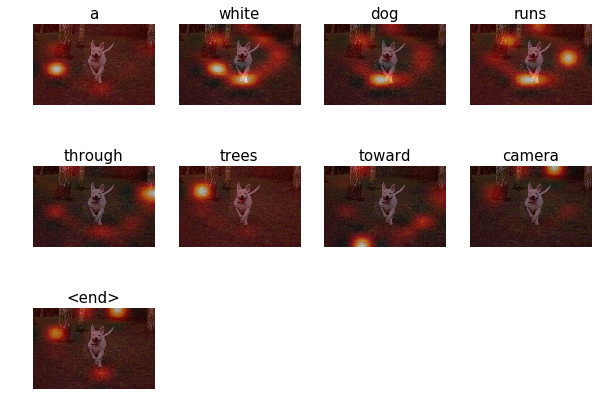

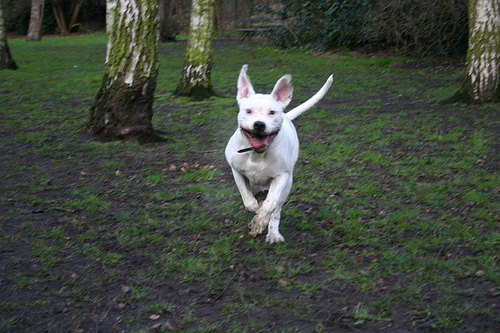

In [121]:
rid = np.random.randint(0, len(image_test))
test_image = image_test[rid]
print(test_image)

real_caption = ' '.join([tokenizer.index_word[i] for i in caption_test[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image)
real_caption=filt_text(real_caption)      

pred_caption=' '.join(result).rsplit(' ', 1)[0]
real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate, weights=(0,0,1,0))

print(f"BELU score: {score*100}")
print ('Real Caption:', real_caption)
print ('Prediction Caption:', pred_caption)

plot_attmap(result, attention_plot, test_image)
Image.open(test_image)

In [122]:
# caption using beam_search
captions=beam_evaluate(test_image)
print(captions)

a white dog


In [101]:
# installing required library
!pip install gTTS

In [123]:
# converting text-to-speach 
from gtts import gTTS
from IPython import display

tts = gTTS(pred_caption, slow = False)
tts.save('pred_caption.mp3')

sound_file = 'pred_caption.mp3'
display.display(display.Audio(sound_file))

In [124]:
# converting text-to-speach using beam_search
tts = gTTS(captions, slow = False)
tts.save('beam_evaluate.mp3')

sound_file = 'beam_evaluate.mp3'
display.display(display.Audio(sound_file))

## Conclusion

- Model was trained and evaluated using Beem Search and Greedy Search algorithms and  is able to detect  accurate caption for unseen images using Encoder-Decoder Attention model . 
- This model can be used as an application for Blind people.